# Analysis

This notebook presents execution and results from:

* Base case analysis
* Scenario analysis
* Sensitivity analysis

The run time is provided at the end of the notebook.

Credit:

* Analysis of the spread of replication results was adapted from Tom Monks (2024) HPDM097 - Making a difference with health data (https://github.com/health-data-science-OR/stochastic_systems) (MIT Licence).
* The function `create_user_controlled_hist()` was adapted from [stack overflow](https://stackoverflow.com/questions/59406167/plotly-how-to-filter-a-pandas-dataframe-using-a-dropdown-menu) and Monks T and Harper A. [Improving the usability of open health service delivery simulation models using Python and web apps](https://doi.org/10.3310/nihropenres.13467.2) [version 2; peer review: 3 approved]. NIHR Open Res 2023, 3:48.

## Set-up

Load required packages.

In [1]:
# pylint: disable=missing-module-docstring
# To ensure any updates to `simulation/` are fetched without needing to restart
# the notebook environment, reload `simulation/` before execution of each cell
%load_ext autoreload
%autoreload 1
%aimport simulation

In [2]:
# pylint: disable=wrong-import-position
import os
import time
from IPython.display import display
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from simulation.logging import SimLogger
from simulation.model import (
    Defaults, Model, Runner, summary_stats, run_scenarios)

Start timer.

In [3]:
start_time = time.time()

Define path to outputs folder.

In [4]:
OUTPUT_DIR = '../outputs/'

Define labels for variables in the dataset.

In [5]:
LABELS = {
    'arrivals': 'Patient arrivals (n)',
    'mean_q_time_nurse': 'Mean wait time for nurse (minutes)',
    'mean_n_consult_time': 'Mean consultation time with nurse (minutes)',
    'mean_time_with_nurse': 'Mean consultation time with nurse (minutes)',
    'mean_nurse_utilisation': 'Mean nurse utilisation',
    'mean_nurse_utilisation_tw': 'Time-weighted mean nurse utilisation',
    'mean_nurse_q_length': 'Time-weighted mean queue length for nurse (n)',
    'patient_inter': 'Patient inter-arrival time',
    'number_of_nurses': 'Number of nurses'
}

## Default run

Run with default parameters.

In [6]:
param = Defaults()
experiment = Runner(param)
experiment.run_reps()

Preview results and save to `.csv` files.

Patient-level results are a large file, so that could be compressed and saved as `.csv.gz`:

```python
# Save file
experiment.patient_results_df.to_csv(
    os.path.join(OUTPUT_DIR, 'example_patient.csv.gz'),
    index=False, compression='gzip')

# Load file
pd.read_csv('filename.csv.gz', compression='gzip
```

However, in may cases, it may not be necessary to save this file - and may be more appropriate to just save the later results.

In [7]:
display(experiment.patient_results_df.head())

,patient_id,arrival_time,q_time_nurse,time_with_nurse,run
0,1,18720.556711,0.0,1.551695,0
1,2,18724.792565,0.0,3.649895,0
2,3,18725.627670,0.0,8.137105,0
3,4,18728.774983,0.0,22.057543,0
4,5,18729.812428,0.0,15.439297,0


In [8]:
display(experiment.run_results_df.head())
experiment.run_results_df.to_csv(
    os.path.join(OUTPUT_DIR, 'example_run.csv'), index=False)

,run_number,scenario,arrivals,mean_q_time_nurse,mean_time_with_nurse,mean_nurse_utilisation,mean_nurse_utilisation_tw,mean_nurse_q_length
0,0,0,10972,0.504541,9.842268,0.499639,0.499740,0.128144
1,1,0,10784,0.514151,10.060481,0.501991,0.502069,0.128347
2,2,0,10854,0.523235,9.925025,0.498130,0.498260,0.132669
3,3,0,10831,0.479149,9.937057,0.498220,0.498269,0.120131
4,4,0,10720,0.461457,10.015904,0.496870,0.497106,0.114510


In [9]:
display(experiment.interval_audit_df.head())
experiment.interval_audit_df.to_csv(
    os.path.join(OUTPUT_DIR, 'example_interval_audit.csv'), index=False)

,resource_name,simulation_time,utilisation,queue_length,running_mean_wait_time,run
0,nurse,18720,0.6,0,0.427625,0
1,nurse,18840,0.4,0,0.425181,0
2,nurse,18960,0.6,0,0.423041,0
3,nurse,19080,1.0,3,0.427408,0
4,nurse,19200,0.6,0,0.440854,0


In [10]:
display(experiment.overall_results_df.head())
experiment.overall_results_df.to_csv(
    os.path.join(OUTPUT_DIR, 'example_overall.csv'), index=False)

,arrivals,mean_q_time_nurse,mean_time_with_nurse,mean_nurse_utilisation,mean_nurse_utilisation_tw,mean_nurse_q_length
mean,10776.741935,0.499037,9.978457,0.497670,0.497804,0.124599
std_dev,115.803272,0.067393,0.115138,0.007524,0.007541,0.017213
lower_95_ci,10734.264952,0.474317,9.936224,0.494910,0.495038,0.118285
upper_95_ci,10819.218919,0.523757,10.020690,0.500430,0.500570,0.130912


## Interactive plots that show the spread of results across replications

In this plot, modeller select the desired metric to view from a drop down list.

Note: These will not be rendered if viewing the notebook on GitHub - instead, scroll down to view non-interactive version of plots.

In [11]:
pio.renderers.default = 'plotly_mimetype'

In [12]:
def create_user_controlled_hist(
    results, exclude_columns=None, name_mappings=None, include_instruct=True
):
    """
    Create a plotly histogram that includes a drop down list that allows a user
    to select which key performance indicator (KPIs) are displayed.

    It has the optional parameter to map the simulation result variable names
    to display a "friendly name" and "units". Users pick a KPI from a drop
    down list. An optional parameter can be used to exclude certain results if
    they are not relevant to the modeller.

    Arguments:
        results (pd.DataFrame)
            Dataframe where rows are replications and columns are KPIs.
        exclude_columns (list, optional)
            List of column numbers to exclude from the dropdown list.
        name_mappings (dict, optional)
            Dictionary mapping column names to labels. If not provided,
            function will default to variable names.
        include_instruct (bool, optional)
            Including the instruction "Select KPI from drop down list" above
            plot. Useful for interactive applications.

    Returns:
        plotly.figure
    """
    # Set as empty dictionary if mappings not provided. The function will later
    # search for a label and find no match, so use the variable name.
    if name_mappings is None:
        name_mappings = {}

    # Initialise figure
    fig = go.Figure()

    # Determine included columns (filter out excluded ones)
    exclude_columns = exclude_columns or []
    included_columns = [col for i, col in enumerate(results.columns)
                        if i not in exclude_columns]

    # Add initial histogram trace, with first column, for initial display
    initial_column = included_columns[0]
    fig.add_trace(go.Histogram(x=results[initial_column]))
    fig.update_layout(
        # If name_mappings is provided, use it; otherwise, use the column name
        xaxis_title=name_mappings.get(initial_column, initial_column),
        yaxis_title='Replications')

    # Generate dropdown buttons for KPI selection
    buttons = [
        {
            'method': 'update',
            'label': name_mappings.get(col, col),
            'args': [
                {'x': [results[col]]},
                {'xaxis': {'title': name_mappings.get(col, col)}}
            ],
        }
        for col in included_columns
    ]

    # Configure dropdown menu
    fig.update_layout(
        showlegend=False,
        updatemenus=[{'buttons': buttons,
                      'direction': 'down',
                      'showactive': True}]
    )

    # Optionally add an instruction annotation
    if include_instruct:
        fig.add_annotation(
            text='Select a KPI from the drop down list',
            xref='paper',
            yref='paper',
            x=0.0,
            y=1.1,  # Position text above the plot
            showarrow=False,
            font={'size': 12},
        )

    return fig

In [13]:
create_user_controlled_hist(
    experiment.run_results_df,
    exclude_columns=[0, 1],
    name_mappings=LABELS,
    include_instruct=True,
)

## Static plots that show the spread of results across replications

Display subsequent plotly express figures as non-interactive figures. This means they will be visible when browsing the notebooks on GitHub. To switch these back to interactive figures, simply remove this line.

In [14]:
pio.renderers.default = 'svg'

In [15]:
def plot_results_spread(
    rep_results, column, file, name_mappings=None, path=OUTPUT_DIR
):
    """
    Plot spread of results from across replications, for chosen column.
    Show figure and save under specified file name.

    Arguments:
        rep_results (pandas.DataFrame)
            The dataframe of replication results.
        column (str):
            Name of column to plot.
        file (str):
            Filename to save figure to.
        name_mappings (dict, optional)
            Dictionary mapping column names to labels. If not provided,
            function will default to variable names.
        path (str):
            Path to save the file to (excluding filename).
    """
    # Set as empty dictionary if mappings not provided. The function will later
    # search for a label and find no match, so use the variable name.
    if name_mappings is None:
        name_mappings = {}

    # Create plot
    fig = px.histogram(rep_results[column])
    fig.update_layout(
        xaxis_title=name_mappings.get(column, column),
        yaxis_title='Frequency',
        template='plotly_white',
        showlegend=False)

    # Show figure
    fig.show()

    # Save figure
    fig.write_image(os.path.join(path, file))

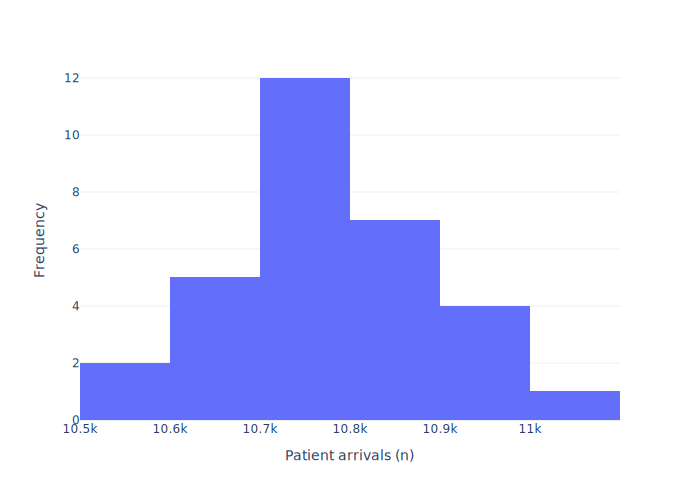

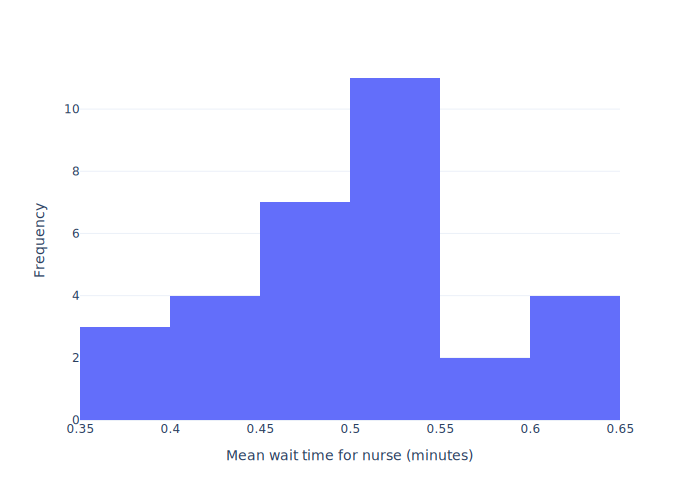

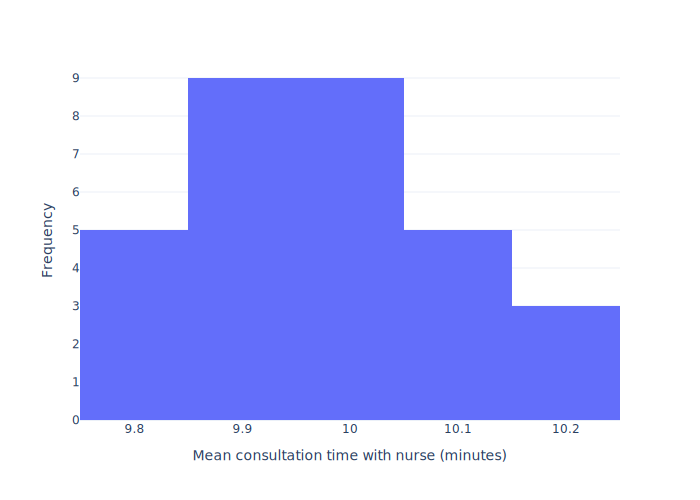

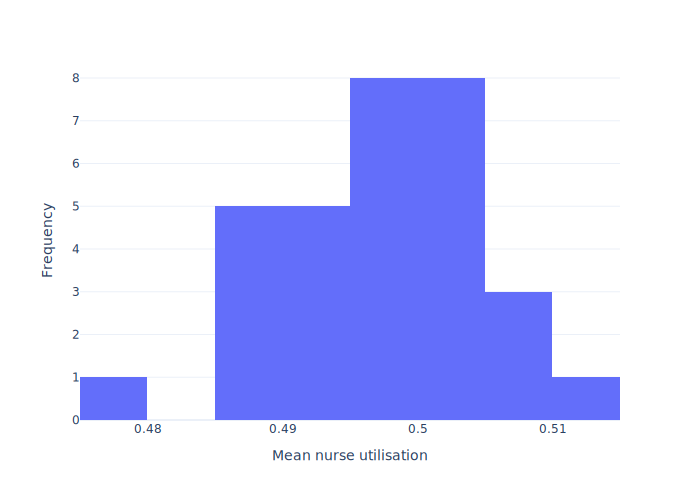

In [16]:
plot_results_spread(
    rep_results=experiment.run_results_df,
    column='arrivals',
    file='spread_arrivals.png',
    name_mappings=LABELS
)

plot_results_spread(
    rep_results=experiment.run_results_df,
    column='mean_q_time_nurse',
    file='spread_nurse_wait.png',
    name_mappings=LABELS
)

plot_results_spread(
    rep_results=experiment.run_results_df,
    column='mean_time_with_nurse',
    file='spread_nurse_time.png',
    name_mappings=LABELS
)

plot_results_spread(
    rep_results=experiment.run_results_df,
    column='mean_nurse_utilisation',
    file='spread_nurse_util.png',
    name_mappings=LABELS
)

## Scenario analysis

We can use the `run_scenarios()` function to run scenarios on the default model, executing it with every possible combination of the specified parameters.

In [17]:
# Run scenarios
scenario_results = run_scenarios(
    {'patient_inter': [3, 4, 5, 6, 7], 'number_of_nurses': [5, 6, 7, 8]}
)

There are 20 scenarios. Running:
{'patient_inter': 3, 'number_of_nurses': 5}
{'patient_inter': 3, 'number_of_nurses': 6}
{'patient_inter': 3, 'number_of_nurses': 7}
{'patient_inter': 3, 'number_of_nurses': 8}
{'patient_inter': 4, 'number_of_nurses': 5}
{'patient_inter': 4, 'number_of_nurses': 6}
{'patient_inter': 4, 'number_of_nurses': 7}
{'patient_inter': 4, 'number_of_nurses': 8}
{'patient_inter': 5, 'number_of_nurses': 5}
{'patient_inter': 5, 'number_of_nurses': 6}
{'patient_inter': 5, 'number_of_nurses': 7}
{'patient_inter': 5, 'number_of_nurses': 8}
{'patient_inter': 6, 'number_of_nurses': 5}
{'patient_inter': 6, 'number_of_nurses': 6}
{'patient_inter': 6, 'number_of_nurses': 7}
{'patient_inter': 6, 'number_of_nurses': 8}
{'patient_inter': 7, 'number_of_nurses': 5}
{'patient_inter': 7, 'number_of_nurses': 6}
{'patient_inter': 7, 'number_of_nurses': 7}
{'patient_inter': 7, 'number_of_nurses': 8}


In [18]:
scenario_results.head()

,run_number,scenario,arrivals,mean_q_time_nurse,mean_time_with_nurse,mean_nurse_utilisation,mean_nurse_utilisation_tw,mean_nurse_q_length,patient_inter,number_of_nurses
0,0,0,14491,1.906132,9.949058,0.667461,0.667636,0.639392,3,5
1,1,0,14406,1.918952,10.148115,0.676693,0.677008,0.640044,3,5
2,2,0,14465,1.976377,9.931685,0.665045,0.665109,0.661766,3,5
3,3,0,14424,1.959961,10.003235,0.667725,0.667792,0.655062,3,5
4,4,0,14387,1.780232,9.980463,0.664761,0.664891,0.592875,3,5


Example plots...

In [19]:
def plot_scenario(results, x_var, result_var, colour_var, name_mappings):
    """
    Plot results from different model scenarios.

    Arguments:
        results (pd.DataFrame):
            Contains results to plot.
        x_var (str):
            Name of variable to plot on X axis.
        result_var (str):
            Name of variable with results, to plot on Y axis.
        colour_var (str|None):
            Name of variable to colour lines with (or set to None).
        name_mappings (dict, optional)
            Dictionary mapping column names to labels. If not provided,
            function will default to variable names.
    """
    # If x_var and colour_var are provided, combine both in a list to use
    # as grouping variables when calculating average results
    if colour_var is not None:
        group_vars = [x_var, colour_var]
    else:
        group_vars = [x_var]

    # Calculate average results from each scenario
    df = (
        results.groupby(group_vars)[result_var]
        .apply(summary_stats)
        .apply(pd.Series)
        .reset_index()
    )
    df.columns = (list(df.columns[:-4]) +
                  ['mean', 'std_dev', 'ci_lower', 'ci_upper'])

    # Plot mean line
    fig = px.line(df, x=x_var, y='mean', color=colour_var)
    fig.update_layout(
        xaxis_title=name_mappings.get(x_var, x_var),
        yaxis_title=name_mappings.get(result_var, result_var),
        legend_title_text=name_mappings.get(colour_var, colour_var),
        template='plotly_white'
    )

    # Plot confidence interval lines
    for ci in ['ci_upper', 'ci_lower']:
        trace = (px.line(df, x=x_var, y=ci, color=colour_var)
                 .update_traces(opacity=0.5, showlegend=False)
                 .select_traces())
        # Add to figure
        fig.add_traces(list(trace))

    return df, fig

Mean wait time for nurse from scenarios with varying patient inter-arrival times and number of nurses.

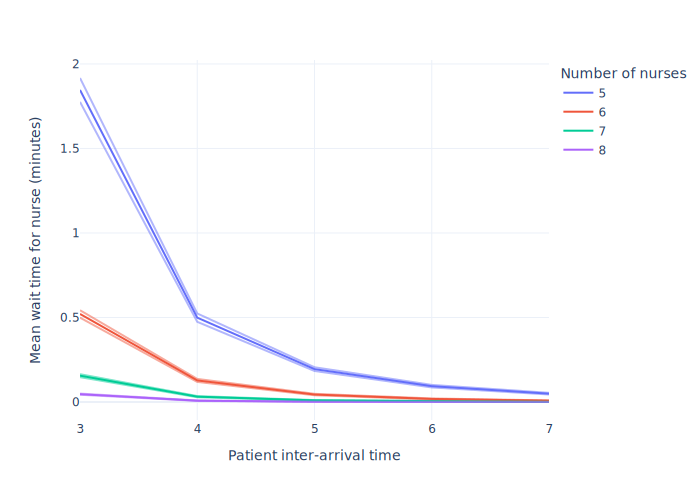

In [20]:
result, plot = plot_scenario(
    results=scenario_results,
    x_var='patient_inter',
    result_var='mean_q_time_nurse',
    colour_var='number_of_nurses',
    name_mappings=LABELS)

plot.show()

plot.write_image(os.path.join(OUTPUT_DIR, 'scenario_nurse_wait.png'))

Mean nurse utilisation with those varying scenarios.

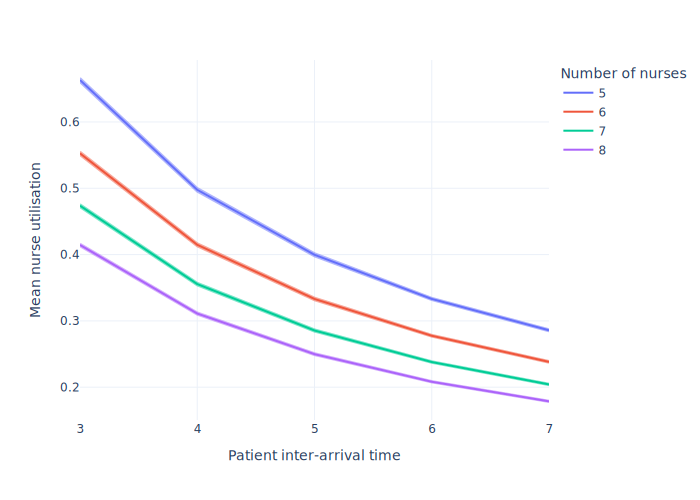

In [21]:
result, plot = plot_scenario(
    results=scenario_results,
    x_var='patient_inter',
    result_var='mean_nurse_utilisation',
    colour_var='number_of_nurses',
    name_mappings=LABELS)

plot.show()

plot.write_image(os.path.join(OUTPUT_DIR, 'scenario_nurse_util.png'))

Example table...

In [22]:
table = result.copy()

# Combine mean and CI into single column, and round
table['mean_ci'] = table.apply(
    lambda row:
    f'{row['mean']:.2f} ({row['ci_lower']:.2f}, {row['ci_upper']:.2f})', axis=1
)

# Convert from long to wide format
table = (
    table
    .pivot(index='patient_inter', columns='number_of_nurses', values='mean_ci')
    .rename_axis('Patient inter-arrival time', axis='index')
    .rename_axis('Number of nurses', axis='columns')
)

# Convert to latex, display and save
table_latex = table.to_latex()
print(table_latex)
with open(os.path.join(OUTPUT_DIR, 'scenario_nurse_util.tex'),
          'w', encoding='utf-8') as tf:
    tf.write(table_latex)

\begin{tabular}{lllll}
\toprule
Number of nurses & 5 & 6 & 7 & 8 \\
Patient inter-arrival time &  &  &  &  \\
\midrule
3 & 0.66 (0.66, 0.67) & 0.55 (0.55, 0.56) & 0.47 (0.47, 0.48) & 0.41 (0.41, 0.42) \\
4 & 0.50 (0.49, 0.50) & 0.41 (0.41, 0.42) & 0.36 (0.35, 0.36) & 0.31 (0.31, 0.31) \\
5 & 0.40 (0.40, 0.40) & 0.33 (0.33, 0.34) & 0.29 (0.28, 0.29) & 0.25 (0.25, 0.25) \\
6 & 0.33 (0.33, 0.33) & 0.28 (0.28, 0.28) & 0.24 (0.24, 0.24) & 0.21 (0.21, 0.21) \\
7 & 0.29 (0.28, 0.29) & 0.24 (0.24, 0.24) & 0.20 (0.20, 0.21) & 0.18 (0.18, 0.18) \\
\bottomrule
\end{tabular}



## Sensitivity analysis

Can use similar code to perform sensitivity analyses.

**How does sensitivity analysis differ from scenario analysis?**

* Scenario analysis focuses on a set of predefined situations which are plausible or relevant to the problem being studied. It can often involve varying multiple parameters simulatenously. The purpose is to understand how the system operates under different hypothetical scenarios.
* Sensitivity analysis varies one (or a small group) of parameters and assesses the impact of small changes in that parameter on outcomes. The purpose is to understand how uncertainty in the inputs affects the model, and how robust results are to variation in those inputs.

In [23]:
# Run scenarios
sensitivity_consult = run_scenarios(
    {'mean_n_consult_time': [8, 9, 10, 11, 12, 13, 14, 15]}
)

There are 8 scenarios. Running:
{'mean_n_consult_time': 8}
{'mean_n_consult_time': 9}
{'mean_n_consult_time': 10}
{'mean_n_consult_time': 11}
{'mean_n_consult_time': 12}
{'mean_n_consult_time': 13}
{'mean_n_consult_time': 14}
{'mean_n_consult_time': 15}


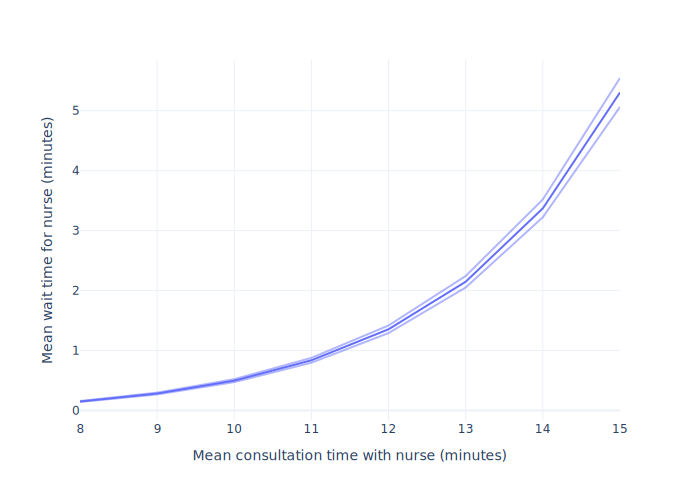

In [24]:
result, plot = plot_scenario(
    results=sensitivity_consult,
    x_var='mean_n_consult_time',
    result_var='mean_q_time_nurse',
    colour_var=None,
    name_mappings=LABELS
)

plot.show()

plot.write_image(os.path.join(OUTPUT_DIR, 'sensitivity_consult_time.png'))

In [25]:
table = result.copy()

# Combine mean and CI into single column, and round
table['mean_ci'] = table.apply(
    lambda row:
    f'{row['mean']:.2f} ({row['ci_lower']:.2f}, {row['ci_upper']:.2f})', axis=1
)

# Select relevant columns and rename
cols = {
    'mean_n_consult_time': 'Mean nurse consultation time',
    'mean_ci': 'Mean wait time for nurse (95 percent confidence interval)'
}
table = table[cols.keys()].rename(columns=cols)

# Convert to latex, display and save
table_latex = table.to_latex()
print(table_latex)
with open(os.path.join(OUTPUT_DIR, 'sensitivity_consult_time.tex'),
          'w', encoding='utf-8') as tf:
    tf.write(table_latex)

\begin{tabular}{lrl}
\toprule
 & Mean nurse consultation time & Mean wait time for nurse (95 percent confidence interval) \\
\midrule
0 & 8 & 0.15 (0.14, 0.16) \\
1 & 9 & 0.28 (0.27, 0.30) \\
2 & 10 & 0.50 (0.47, 0.52) \\
3 & 11 & 0.84 (0.80, 0.88) \\
4 & 12 & 1.36 (1.29, 1.42) \\
5 & 13 & 2.15 (2.05, 2.24) \\
6 & 14 & 3.37 (3.22, 3.52) \\
7 & 15 & 5.30 (5.06, 5.54) \\
\bottomrule
\end{tabular}



## NaN results

Note: In this model, if patients are still waiting to be seen at the end of the simulation, they will have NaN results.

In [26]:
param = Defaults()
param.patient_inter = 2
nan_experiment = Runner(param)
nan_experiment.run_reps()
nan_experiment.patient_results_df.tail()

,patient_id,arrival_time,q_time_nurse,time_with_nurse,run
667686,21586,61913.030043,NaN,NaN,30
667687,21587,61915.384561,NaN,NaN,30
667688,21588,61915.421934,NaN,NaN,30
667689,21589,61917.817910,NaN,NaN,30
667690,21590,61919.845349,NaN,NaN,30


## Example run with logs

The `SimLogger` class is used to log events during the simulation. These can be print to the console (`log_to_console`) or saved to a file (`log_to_file`).

This will output lots of information to the screen - currently set to give information on each patient as they arrive and then see the nurse. Therefore, it is only best used when running the simulation for a short time with few patients.

The logs in `model.py` can be altered to print your desired information during the simulation run, which can be helpful during development.

In [27]:
# Mini run of simulation with logger enabled
param = Defaults()
param.warm_up_period = 50
param.data_collection_period = 100
param.number_of_runs = 1
param.cores = 0
param.logger = SimLogger(log_to_console=True, log_to_file=False)

model = Model(param, run_number=0)
model.run()

2025-01-30 13:21:27,913 - INFO - logging.py:log():128 - Initialised model: {'param': <simulation.model.Defaults object at 0x72e3937838b0>, 'run_number': 0, 'env': <simpy.core.Environment object at 0x72e39373c6e0>, 'nurse': <simulation.model.MonitoredResource object at 0x72e39373c830>, 'patients': [], 'nurse_time_used': 0, 'nurse_consult_count': 0, 'running_mean_nurse_wait': 0, 'audit_list': [], 'results_list': [], 'patient_inter_arrival_dist': <simulation.model.Exponential object at 0x72e39373c590>, 'nurse_consult_time_dist': <simulation.model.Exponential object at 0x72e39388afd0>}
2025-01-30 13:21:27,913 - INFO - logging.py:log():128 - Parameters: {'_initialising': False, 'patient_inter': 4, 'mean_n_consult_time': 10, 'number_of_nurses': 5, 'warm_up_period': 50, 'data_collection_period': 100, 'number_of_runs': 1, 'audit_interval': 120, 'scenario_name': 0, 'cores': 0, 'logger': <simulation.logging.SimLogger object at 0x72e393966970>}
2025-01-30 13:21:27,914 - INFO - logging.py:log():12

This will align with the recorded results of each patient (though we only save those that arrive after the warm-up period).

In [28]:
# Compare to patient-level results
display(model.results_list)

[{'patient_id': 1,
  'arrival_time': 51.90400587259546,
  'q_time_nurse': 0.0,
  'time_with_nurse': 18.07891954142075},
 {'patient_id': 2,
  'arrival_time': 51.963434706622714,
  'q_time_nurse': 0.0,
  'time_with_nurse': 3.1020092355006064},
 {'patient_id': 3,
  'arrival_time': 74.3494580155259,
  'q_time_nurse': 0.0,
  'time_with_nurse': 26.744513862017026},
 {'patient_id': 4,
  'arrival_time': 77.53382703300574,
  'q_time_nurse': 0.0,
  'time_with_nurse': 0.7481033661053572},
 {'patient_id': 5,
  'arrival_time': 78.93233230430721,
  'q_time_nurse': 0.0,
  'time_with_nurse': 0.5277574384602378},
 {'patient_id': 6,
  'arrival_time': 86.81473043550623,
  'q_time_nurse': 0.0,
  'time_with_nurse': 2.4349563515001904},
 {'patient_id': 7,
  'arrival_time': 89.78326290873765,
  'q_time_nurse': 0.0,
  'time_with_nurse': 9.665598479334754},
 {'patient_id': 8,
  'arrival_time': 89.80720556833339,
  'q_time_nurse': 0.0,
  'time_with_nurse': 7.004542644523265},
 {'patient_id': 9,
  'arrival_time'

## Run time

In [29]:
# Get run time in seconds
end_time = time.time()
runtime = round(end_time - start_time)

# Display converted to minutes and seconds
print(f'Notebook run time: {runtime // 60}m {runtime % 60}s')

Notebook run time: 0m 28s
